ImageDataGenerator → To load images from folders and augment them (e.g., rotate, zoom).

ResNet50 → A pre-trained CNN that we’ll reuse to classify X-ray images.

preprocess_input → Prepares images the same way they were during ResNet50 training.

decode_predictions → Converts model outputs into human-readable labels (used for pre-trained ImageNet).

Dense, GlobalAveragePooling2D → Layers for our custom classifier head.

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D,Dropout
from tensorflow.keras.optimizers import Adam
import os

In [2]:
data = r"C:\\Deep Learning Tasks\\CNN\\X_RAY\\chest_xray_Dataset"

In [3]:
train_data = os.path.join(data, 'train')
test_data = os.path.join(data, 'test')
val_data = os.path.join(data, 'val')

ImageDataGenerator helps prepare images for training.

rescale=1./255 → converts pixel values (0–255) to (0–1) for normalization.

rotation_range, zoom_range, horizontal_flip → add random transformations to make the model more robust (data augmentation).

In [4]:
train_datagenerator = ImageDataGenerator(
    rescale = 1./255,
    horizontal_flip = True,
    vertical_flip = True,
    zoom_range = 0.3,
    rotation_range = 25,
    shear_range = 0.2,
    brightness_range=(0.8, 1.2)
)


test_datagenerator = ImageDataGenerator(rescale=1./255)
val_datagenerator = ImageDataGenerator(rescale=1./255)

This line reads images from folders automatically.

target_size=(224, 224) → ResNet50 expects this input size.

batch_size=32 → 32 images are loaded per training step.

class_mode='binary' → because we have two classes (NORMAL, PNEUMONIA).

In [5]:
train_generator = train_datagenerator.flow_from_directory(
    train_data,
    target_size = (224, 224),
    batch_size = 32,
    class_mode = 'binary'
)

Found 5216 images belonging to 2 classes.


In [6]:
test_generator = train_datagenerator.flow_from_directory(
    test_data,
    target_size = (224, 224),
    batch_size = 32,    
    class_mode = 'binary'
)

Found 624 images belonging to 2 classes.


In [7]:
val_generator = val_datagenerator.flow_from_directory(
    val_data,
    target_size = (224, 224),
    batch_size = 32,
    class_mode = 'binary'
)

Found 16 images belonging to 2 classes.


ResNet50 is a pre-trained CNN that already knows how to detect edges, shapes, and textures.

weights='imagenet' → loads the learned weights from ImageNet.

include_top=False → we remove its last classification layer (we’ll add our own).

trainable=False → we freeze its layers so their weights don’t change during training (to prevent overfitting).

In [8]:
base_model  = ResNet50(
    weights= 'imagenet',
    include_top = False,
    input_shape = (224, 224, 3))

base_model.trainable = False  # Freeze base layers

GlobalAveragePooling2D() → reduces each feature map into a single value (reduces parameters).

Dense(128, activation='relu') → adds a fully connected layer with 128 neurons.

Dense(1, activation='sigmoid') → outputs a probability (0 = normal, 1 = pneumonia).

The new model (final_model) combines ResNet50 features + custom classifier head.

In [ ]:
from tensorflow.keras.layers import BatchNormalization

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)  
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)
final_model = Model(inputs=base_model.input, outputs=x)


In [10]:
final_model.compile(
    optimizer = Adam(learning_rate= 0.001),
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)
final_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 25,691,009 (98.00 MB)

 Trainable params: 2,101,249 (8.02 MB)

 Non-trainable params: 23,589,760 (89.99 MB)

In [11]:
#  Unfreeze last 20 layers of ResNet50 for fine-tuning
for layer in base_model.layers[-20:]:
    layer.trainable = True

# Re-compile with lower learning rate for fine-tuning
final_model.compile(
    optimizer = Adam(learning_rate=1e-5),
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)

In [12]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
 
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
 
history = final_model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=[early_stop, reduce_lr]
)

C:\Users\ShahlaSherin\AppData\Roaming\Python\Python310\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 1015s 6s/step - accuracy: 0.7031 - loss: 0.6418 - val_accuracy: 0.5000 - val_loss: 0.6796 - learning_rate: 1.0000e-05
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 911s 6s/step - accuracy: 0.7992 - loss: 0.4918 - val_accuracy: 0.4375 - val_loss: 0.6870 - learning_rate: 1.0000e-05
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 990s 6s/step - accuracy: 0.8315 - loss: 0.4574 - val_accuracy: 0.6250 - val_loss: 0.5990 - learning_rate: 1.0000e-05
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 883s 5s/step - accuracy: 0.8428 - loss: 0.4286 - val_accuracy: 0.6875 - val_loss: 0.5967 - learning_rate: 1.0000e-05
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 491s 3s/step - accuracy: 0.8537 - loss: 0.4202 - val_accuracy: 0.6875 - val_loss: 0.5848 - learning_rate: 1.0000e-05
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 489s 3s/step - accuracy: 0.8581 - loss: 0.3829 - val_accuracy: 0.6250 - val_loss: 0.7880 - learning_rate: 1.0000e-05
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 470s 3s/step - ac

In [13]:
test_loss,test_acc = final_model.evaluate(test_generator)
print(f'test accuracy:{test_acc*100:.2f}%')                                               # Evaluates model performance on unseen test images.

20/20 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.8191 - loss: 0.4546
test accuracy:83.81%


Create Grad-CAM Function

Grad-CAM = Gradient-weighted Class Activation Mapping
It shows which parts of an image influenced the model’s decision.

In [14]:
def gradcam_heatmap(img_array, model, last_conv_layer_name):
    grad_model = tf.keras.models.Model(
        [model.inputs], 
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, 0]

    grads = tape.gradient(loss, conv_outputs)[0]
    conv_outputs = conv_outputs[0]
    weights = tf.reduce_mean(grads, axis=(0, 1))

    cam = np.zeros(conv_outputs.shape[0:2], dtype=np.float32)
    for i, w in enumerate(weights):
        cam += w * conv_outputs[:, :, i]
    
    cam = np.maximum(cam, 0)
    cam = cam / np.max(cam)
    return cam


In [15]:
def show_gradcam(image_path, model, layer_name='conv5_block3_out'):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    heatmap = gradcam_heatmap(img_array, model, layer_name)
    heatmap = cv2.resize(heatmap, (224, 224))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    original = cv2.imread(image_path)
    original = cv2.resize(original, (224, 224))
    superimposed = cv2.addWeighted(original, 0.6, heatmap, 0.4, 0)

    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1)
    plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
    plt.title("Original Image")

    plt.subplot(1,2,2)
    plt.imshow(cv2.cvtColor(superimposed, cv2.COLOR_BGR2RGB))
    plt.title("Grad-CAM Visualization")
    plt.show()


C:\Users\ShahlaSherin\AppData\Roaming\Python\Python310\site-packages\keras\src\models\functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


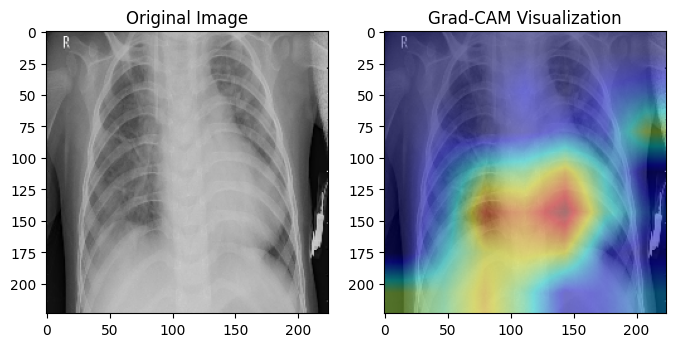

In [16]:
sample_image = os.path.join(test_data, "PNEUMONIA", os.listdir(os.path.join(test_data, "PNEUMONIA"))[10])
show_gradcam(sample_image, final_model)


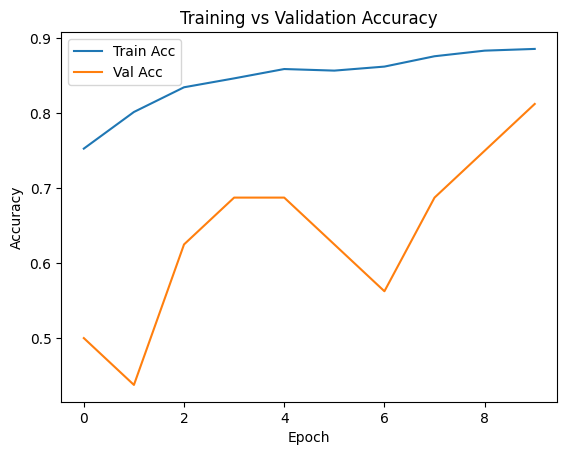

In [17]:
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Prediction: NORMAL (0.0000)


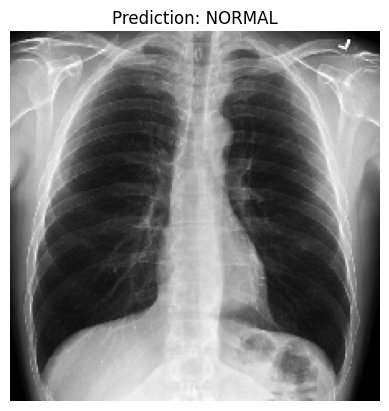

In [18]:
from tensorflow.keras.preprocessing import image
import numpy as np

def predict_xray(model, img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    prediction = model.predict(img_array)[0][0]

    if prediction > 0.5:
        label = "PNEUMONIA"
    else:
        label = "NORMAL"

    print(f"Prediction: {label} ({prediction:.4f})")

    plt.imshow(img)
    plt.title(f"Prediction: {label}")
    plt.axis('off')
    plt.show()


img_path = r'C:\Deep Learning Tasks\CNN\X_RAY\sample\normal\normal (1) 1.jpg'
predict_xray(final_model, img_path)
